## Compare UI Ekman and UI SST

In [1]:
## import packages
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# from global_land_mask import globe
import glob
import os
# import math
import my_functions

In [47]:
## import data
os.chdir("/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/")
TSM = xr.open_dataset('Surface_stress/Turbulent_mean/Turbulent_mean_weekly.nc')
UI_SST = UI_SST = xr.open_dataset('CoastNET_SST_UI.nc')

In [48]:
# use my upwelling function (from my_functions.py)
UI_Ek = my_functions.upwelling_index(TSM, TSM.lat, TSM.lon, TSM.metss, TSM.mntss)

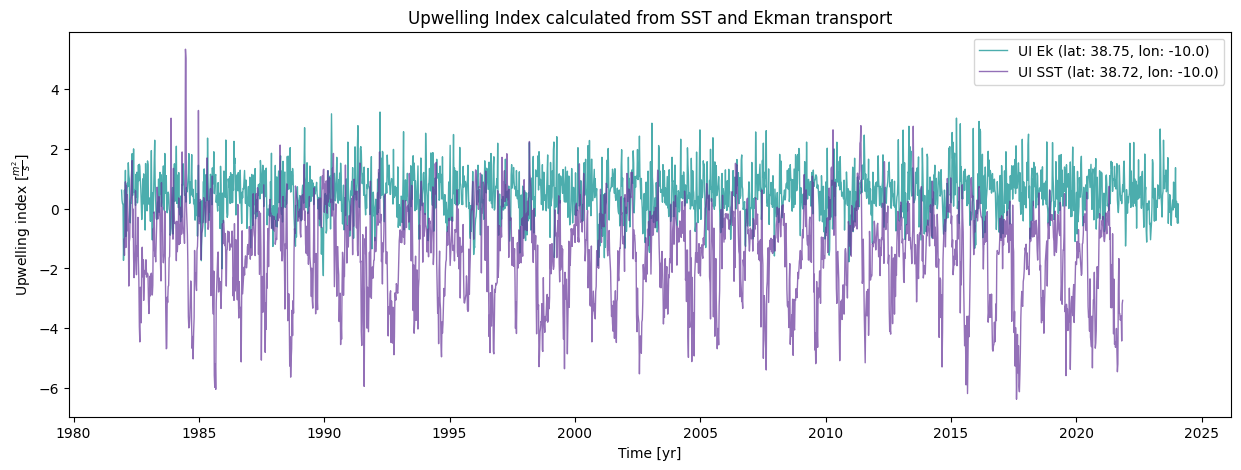

In [67]:
fig = plt.figure(figsize=(15,5))
plt.plot(UI_Ek.time, UI_Ek.upwelling_index.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 1)
plt.plot(UI_SST.time, UI_SST.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 1)
plt.legend()
plt.title('Upwelling Index calculated from SST and Ekman transport')
plt.xlabel('Time [yr]')
plt.ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');

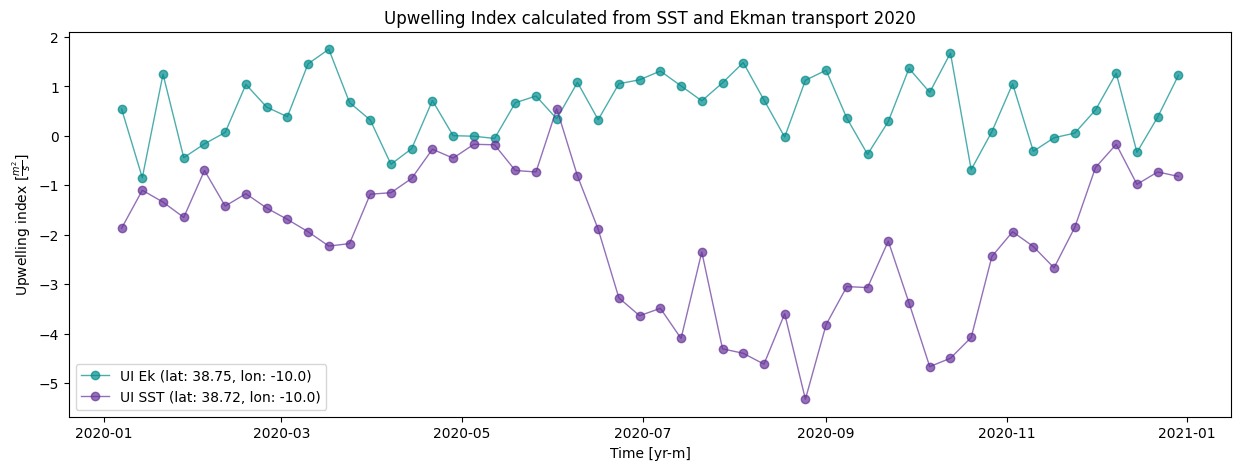

In [79]:
fig = plt.figure(figsize=(15,5))
plt.plot(UI_Ek.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_Ek.upwelling_index.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 1, marker = 'o')
plt.plot(UI_SST.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_SST.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 1, marker = 'o')
plt.legend()
plt.title('Upwelling Index calculated from SST and Ekman transport 2020')
plt.xlabel('Time [yr-m]')
plt.ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');